In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb

    path_andrey = '/Home/siv30/wad005/master/GRB/MATLAB/andrey_mezentsev/'

else:
    %run /Users/andreas/fun/useful_py_func/matplotlib_custom_style_and_macros.py
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    path_andrey = '/Users/andreas/phys/master/GRB/MATLAB/andrey_mezentsev/'
    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Function

In [72]:
import numpy as np
from numpy.polynomial.polynomial import polyval,polyfit
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#TODO: must also calculate T50 in the function --> return T90 and T50 

def estimate_duration(GRB_id=None, binsize=None, tlagg_asim=None, T0=None, bak_interval=None, poly_degree=0, mean_start_time=None, info_text=None, export=False):
    """
    Calculate the T90 duration of a given Gamma-Ray Burst (GRB).

    Parameters:
    GRB_id (str): The identification of the GRB.
    binsize (float): The size of the bins for the histogram.
    tlagg_asim (float): The time lag given in seconds.
    T0 (str): The initial time in ISO format.
    bak_interval (list of tuples): The intervals for the background estimation.
    poly_degree (int, optional): The degree of the polynomial for the background fit. Defaults to 0.
    mean_start_time (float): The time at which the mean of the cumulative counts is estimated. Defaults to None
    info_text (str, optional): Information regarding the T90 estimation. Printed in the exported PDF.
    export (bool): Exporting info_text and figures to a PDF file. Defaults to False.

    Returns:
    float: The T90 duration of the GRB.
    PDF: If export parameter is True and info_text is provided.
    """
    
    # Check if all necessary parameters are provided
    if not all([GRB_id!=None, binsize!=None, tlagg_asim!=None, T0!=None, bak_interval!=None]):
        raise ValueError("All parameters must be provided.")
   
    # Load data
    asimData = pd.read_csv(f'{path_andrey}{GRB_id}.csv')
    asimData['tus'] /= 1e6
    asimData['tus'] += tlagg_asim
    asimData.sort_values(by=['tus'],inplace=True,ignore_index=True)
    tus_asim = asimData['tus'].to_numpy()

    # Calculate T0
    T0 = datetime.fromisoformat(T0) + timedelta(seconds=tlagg_asim)
    print(f'T0 {T0}, applied time lagg: {np.round(tlagg_asim,5)} s')

    # Create histogram
    grb_hist = np.histogram(tus_asim, np.arange(tus_asim[0], tus_asim[-1] + binsize, binsize))
    grb_counts, grb_edges = grb_hist[0], grb_hist[1]

    # Initialize background level array
    background_level = np.zeros_like(grb_counts) #returning array of zeros in the same shape as grb_counts

    # Calculate background level for each interval
    # Create a boolean array for the background mask
    bak_mask = np.zeros_like(grb_counts, dtype=bool)
    for interval in bak_interval:
        ti_bkg, tf_bkg = interval
        interval_mask = (grb_edges[:-1] >= ti_bkg) & (grb_edges[:-1] < tf_bkg)
        bak_mask = np.logical_or(bak_mask, interval_mask)

    # Use polynomial of n-th degree to fit the background level
    polyCoefs = polyfit(grb_edges[:-1][bak_mask], grb_counts[bak_mask], poly_degree)

    # Calculate the background level for the entire light curve array using the fitted polynomial
    background_level = polyval(grb_edges[:-1], polyCoefs)

    # Subtract background
    background_subtracted = grb_counts - background_level

    # Calculate cumulative sum of background subtracted counts
    cumulative_counts = np.cumsum(background_subtracted)
    
    # Finding start index for start of calculating the mean of the total cumulative counts; inserted to the left (a[i-1] < t <= a[i])
    index_cumulative_start = np.searchsorted(grb_edges[:-1],mean_start_time)

    total_counts = np.mean(cumulative_counts[index_cumulative_start:])
    
    # Calculate T90
    t1_90 = grb_edges[np.searchsorted(cumulative_counts, 0.05 * total_counts)]
    t2_90 = grb_edges[np.searchsorted(cumulative_counts, 0.95 * total_counts)]
    T90 = t2_90 - t1_90
    
    # Calculate T50
    t1_50 = grb_edges[np.searchsorted(cumulative_counts, 0.25 * total_counts)]
    t2_50 = grb_edges[np.searchsorted(cumulative_counts, 0.75 * total_counts)]

    T50 = t2_50 - t1_50
    
    
    if export!=False and info_text!=None:
        # Create a new PDF file
        pdf_pages = PdfPages(f'{GRB_id}_T90report.pdf')
        
        # Create a blank figure for the text
        fig0 = plt.figure(figsize=(11, 8))
        plt.axis('off')
        plt.text(0, 0, info_text, fontsize=16)
        pdf_pages.savefig(fig0)

        # Save figures to the PDF
        
        # Figure 1: Light Curve
        fig1 = plt.figure(figsize=(11, 8))
        plt.step(grb_edges[:-1], grb_counts, color='black')
        plt.title(f'Light Curve for {GRB_id}')
        plt.xlabel('Time from T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        plt.plot(grb_edges[:-1][bak_mask], background_level[bak_mask], color='blue', linestyle='-', label='Background Level')
        for interval in bak_interval:
            plt.axvline(x=interval[0], ymin=0, ymax=0.68, color='g', linestyle='--')
            plt.axvline(x=interval[1], ymin=0, ymax=0.68, color='r', linestyle='--')
        plt.legend()
        pdf_pages.savefig(fig1)

        # Figure 2: Background Subtracted Light Curve
        fig2 = plt.figure(figsize=(11, 8))
        plt.step(grb_edges[:-1], background_subtracted, color='black', where='post')
        plt.title(f'Background Subtracted Light Curve for {GRB_id}')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        for interval in bak_interval:
            plt.axvline(x=interval[0], ymin=0, ymax=0.68, color='g', linestyle='--')
            plt.axvline(x=interval[1], ymin=0, ymax=0.68, color='r', linestyle='--')
        plt.axhline(y=0, color='blue', linestyle='--', label='Background Level')
        plt.legend()
        pdf_pages.savefig(fig2)

        # Figure 3: Cumulative Counts
        fig3 = plt.figure(figsize=(11, 8))
        plt.plot(grb_edges[:-1], cumulative_counts, color='black')
        plt.title(f'Cumulative Counts for {GRB_id}')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Cumulative Counts per {format(binsize*1000, ".0f")} ms')
        plt.axhline(y=0.05 * total_counts, color='g', linestyle='--', label='0.05%')
        plt.axhline(y=0.25 * total_counts, color='cyan', linestyle='--', label='0.25%')
        plt.axhline(y=0.75 * total_counts, color='purple', linestyle='--', label='0.75%')
        plt.axhline(y=0.95 * total_counts, color='r', linestyle='--', label='0.95%')
        plt.axhline(y=total_counts, color='darkgray', linestyle='--', label='~100%')
        plt.axvline(x=grb_edges[index_cumulative_start], color='orange', linestyle='--', label='Start of mean total')
        plt.axhline(y=0, linestyle='--', color='black')
        plt.legend()
        pdf_pages.savefig(fig3)
        
        # Plot 4: Background Subtracted Light Curve with T90 Start & Stop
        fig4 = plt.figure(figsize=(11, 8))
        plt.step(grb_edges[:-1], background_subtracted, color='black', where='post')
        plt.title(f'{GRB_id} Background Subtracted Light Curve')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        plt.axvline(x=grb_edges[np.searchsorted(grb_edges[:-1],t1_90)], ymin=0, ymax=0.68, color='g', linestyle='--')
        plt.axvline(x=grb_edges[np.searchsorted(grb_edges[:-1],t2_90)], ymin=0, ymax=0.68, color='r', linestyle='--',label=f'T90: {round(T90,3)} s')
        plt.axvline(x=grb_edges[np.searchsorted(grb_edges[:-1],t1_50)], ymin=0, ymax=0.68, color='cyan', linestyle='--')
        plt.axvline(x=grb_edges[np.searchsorted(grb_edges[:-1],t2_50)], ymin=0, ymax=0.68, color='purple', linestyle='--',label=f'T50: {round(T50,3)} s')
        plt.axhline(y=0, color='blue', linestyle='--', label='Background Level')
        plt.legend()
        pdf_pages.savefig(fig4)

        # Close the PDF file
        pdf_pages.close()
        
        return T90, T50
    else:
        # Plotting without exporting

        # Plot 1: Light Curve
        print(f'Mean background level: {np.round(np.mean(background_level))} / {binsize} [counts/s]')
        plt.step(grb_edges[:-1], grb_counts, color='black')
        plt.title(f'Light Curve for {GRB_id}')
        plt.xlabel('Time from T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        plt.plot(grb_edges[:-1][bak_mask], background_level[bak_mask], color='blue', linestyle='-', label='Background Level')
        for interval in bak_interval:
            plt.axvline(x=interval[0], ymin=0, ymax=0.68, color='g', linestyle='--')
            plt.axvline(x=interval[1], ymin=0, ymax=0.68, color='r', linestyle='--')
        plt.legend()
        plt.show()

        # Plot 2: Background Subtracted Light Curve
        print(f'Mean background level: {np.round(np.mean(background_level))} / {binsize} [counts/s]')
        plt.step(grb_edges[:-1], background_subtracted, color='black', where='post')
        plt.title(f'Background Subtracted Light Curve for {GRB_id}')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        for interval in bak_interval:
            plt.axvline(x=interval[0], ymin=0, ymax=0.68, color='g', linestyle='--')
            plt.axvline(x=interval[1], ymin=0, ymax=0.68, color='r', linestyle='--')
        plt.axhline(y=0, color='blue', linestyle='--', label='Background Level')
        plt.legend()
        plt.show()

        # Plot 3: Cumulative Counts
        print(f"T90 for {GRB_id} = {np.round(T90,5)} s")
        print(f'Mean total counts: {np.round(total_counts)} estimated from T0 {mean_start_time} --> {np.round(grb_edges[-1],3)}')
        plt.plot(grb_edges[:-1], cumulative_counts, color='black')
        plt.title(f'Cumulative Counts for {GRB_id}')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Cumulative Counts per {format(binsize*1000, ".0f")} ms')
        plt.axhline(y=0.05 * total_counts, color='g', linestyle='--', label='0.05%')
        plt.axhline(y=0.25 * total_counts, color='cyan', linestyle='--', label='0.25%')
        plt.axhline(y=0.75 * total_counts, color='purple', linestyle='--', label='0.75%')
        plt.axhline(y=0.95 * total_counts, color='r', linestyle='--', label='0.95%')
        plt.axhline(y=total_counts, color='darkgray', linestyle='--', label='~100%')
        plt.axvline(x=grb_edges[index_cumulative_start], color='orange', linestyle='--', label='Start of mean total')
        plt.axhline(y=0, linestyle='--', color='black')
        plt.legend()
        plt.show()
        
        # Plot 4: Background Subtracted Light Curve with T90 Start & Stop
        plt.step(grb_edges[:-1], background_subtracted, color='black', where='post')
        plt.title(f'{GRB_id} Background Subtracted Light Curve')
        plt.xlabel('T-T0 (s)')
        plt.ylabel(f'Counts per {format(binsize*1000, ".0f")} ms')
        plt.axvline(x=grb_edges[np.searchsorted(grb_edges[:-1],t1_90)], ymin=0, ymax=0.68, color='g', linestyle='--')
        plt.axvline(x=grb_edges[np.searchsorted(grb_edges[:-1],t2_90)], ymin=0, ymax=0.68, color='r', linestyle='--',label=f'T90: {round(T90,3)} s')
        plt.axvline(x=grb_edges[np.searchsorted(grb_edges[:-1],t1_50)], ymin=0, ymax=0.68, color='cyan', linestyle='--')
        plt.axvline(x=grb_edges[np.searchsorted(grb_edges[:-1],t2_50)], ymin=0, ymax=0.68, color='purple', linestyle='--',label=f'T50: {round(T50,3)} s')
        plt.axhline(y=0, color='blue', linestyle='--', label='Background Level')
        plt.legend()
        plt.show()

        return T90, T50

# Estimating T90; General Procedure
    1) importing the ASIM data (Andrey data), applying cross correlation time lagg from previous calculations
    2) binning by 2 ms (or what is appropriate for the specific light curve)
    3) estimating background --> subtracting background from LC using a polynomial of n-th (0->constant) degree to fit the background 
    4) apply np.cumsum() on binned data
    5) Find total number of cumulative counts, calculate % and find T90

## General Notes        
    Unrealiable background --> is overestimated resulting in negative counts
    Tried with a quadratic fit, but error persists --> Using linear fit to estimate background due to short interval
    Clipping the background subtracted lightcurve to 0, results in T90 overestimated --> Cumulative curve is monotonically increasing!
        
    => We learned that we have to keep the negative counts in the background subtracted lightcurve for the cumulative curve to converge.
    
    => We approxiame the total number of cumulative counts after convergence by calculating the mean of the last N bins in the background subtracted light curve. This N parameter affect the T90 estimation
    
    => Important to choose an appropriate binsize that minimizes noise in the light curve. If the cumulative sum doesn't converge, the T90 estimation fails. Therefore it's important to move the N parameter (mean_index), when binsize is changed

# T90

## GRB 190606A

In [84]:
info_GRB190606A = "GRB190606A: Very short and bright burst, good starting point!\n\n T0=2019-06-06 01:55:06.781982 (cross correlated with KW) \n\n Background: Polynomial approximation (0-th degree), 1. Interval ti=T0-1.0 s, tf=T0-0.2 s.\n 2. Interval: ti = T0+0.4, tf= T0+0.85\n\n T90 ends at significant count rate drop.\n T90 estimations (binsize, mean_start_time, T90):\n- 1ms, T0+0.5: 0.165 s\n- 2ms, T0+0.5: 0.164 s\n- 4ms, T0+0.5: 0.164 s\n- 8ms, T0+0.5: 0.168 s\n- 16ms, T0+0.5: 0.160 s\n\n T50 estimations (binsize, mean_start_time, T50):\n- 1ms, T0+0.5: 0.053 s\n- 2ms, T0+0.5: 0.054 s\n- 4ms, T0+0.5: 0.056 s\n- 8ms, T0+0.5: 0.056 s\n- 16ms, T0+0.5: 0.048 s\n"

T0 2019-06-06 01:55:06.781982, applied time lagg: -0.53662 s


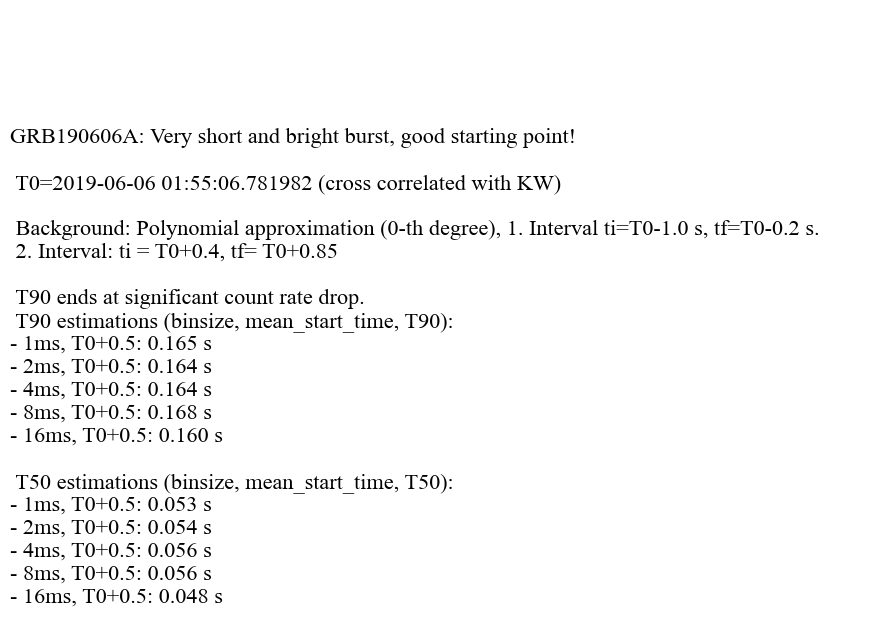

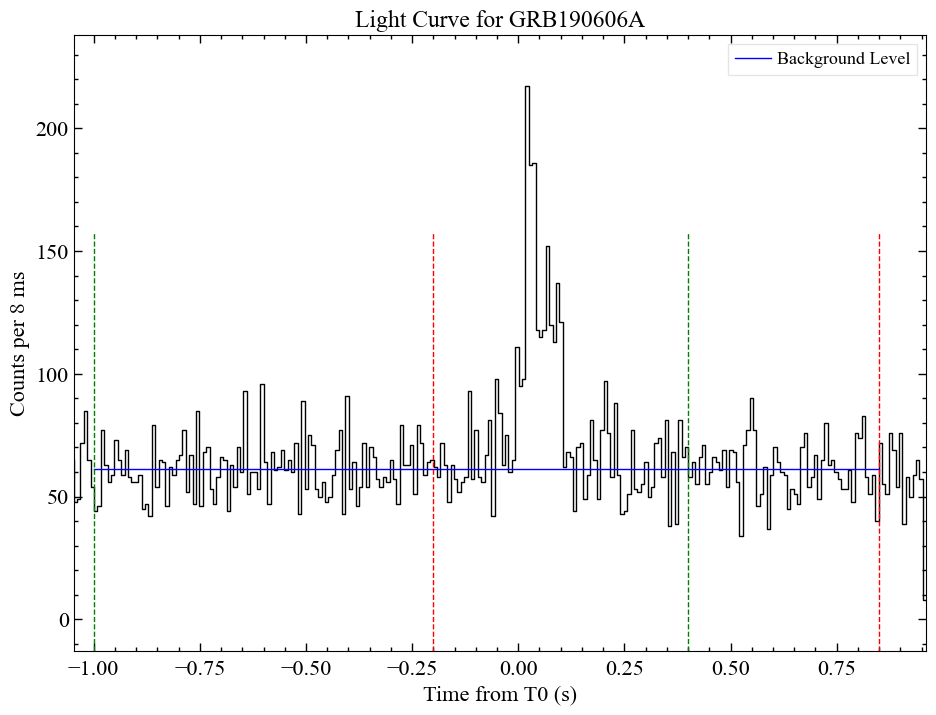

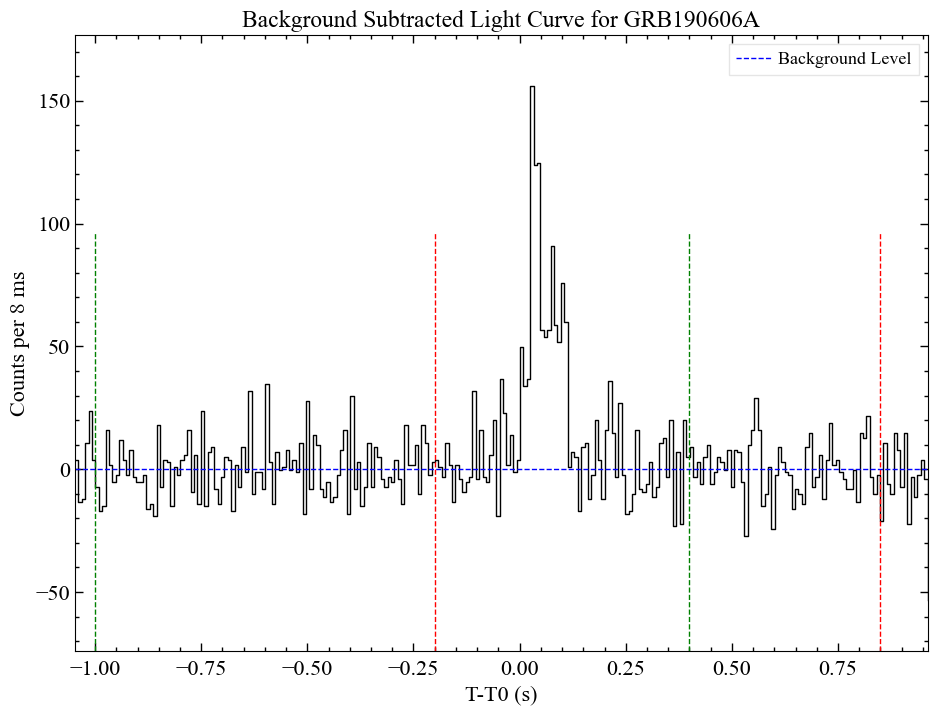

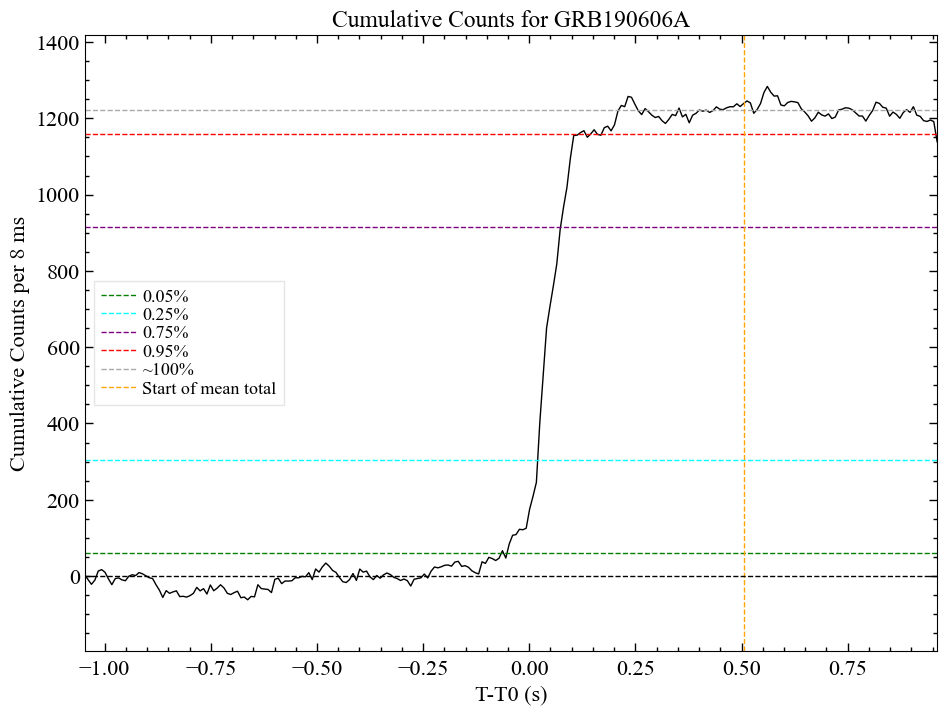

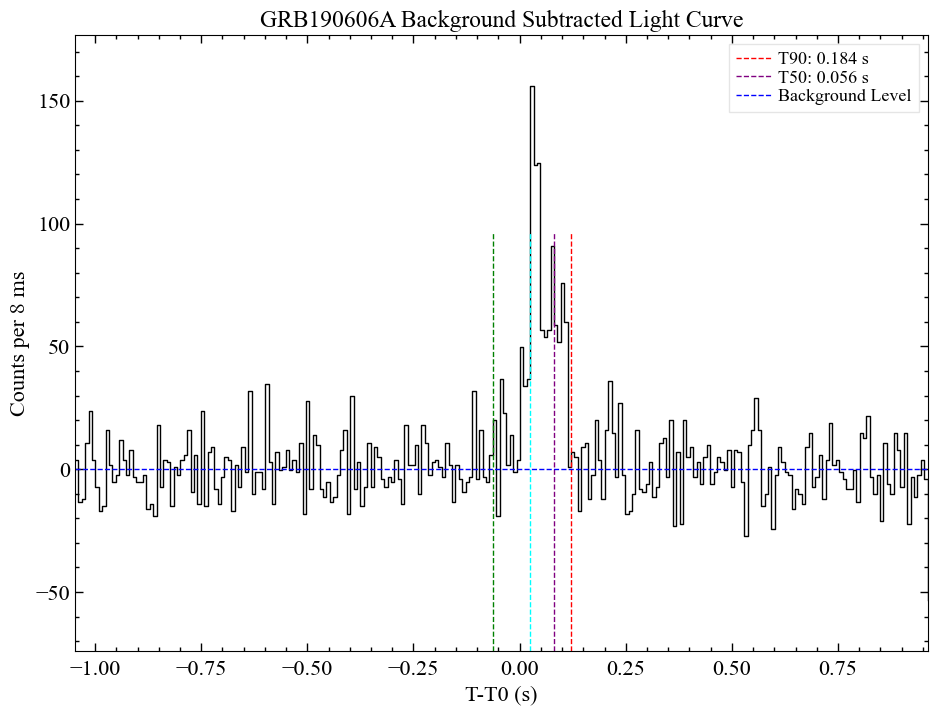

In [85]:
T90 = estimate_duration('GRB190606A', 0.008, -0.5366225269343781, '2019-06-06T01:55:07.318605', bak_interval=[(-1, -0.2),(0.4,0.85)], mean_start_time=0.5, poly_degree=0,
                    export=True,  info_text=info_GRB190606A)

## GRB 201227A
    -Difficult to calculate the background on the interval
        --> Check if ratemeter data is availible before current trigger burst
        
    -Background level is too high. See this before and after the inflection point / exponential
    
    -T90 reported by Fermi: 0.1 s (50-300 keV) => Suggesting to also calculate the backgorund after the burst
        --> Have implemented multiple interval for background estimation
    -

info_GRB201227A = "GRB 201227A: Short, bright, another good bright burst!\n\nT90 ends at significant count rate drop.\n\nBackground: Polynomial approximation (0-th degree), ti=- s, tf=- s.\n\nT90 estimations (binsize, mean_index, T90):\n- 1ms, -:  s\n- 2ms, -: 0. s\n- 4ms, -: 0. s\n- 8ms, -: 0. s\n- 16ms, -: 0. s\n"

T0 2020-12-27 15:14:06.322667, applied time lagg: -0.531 s


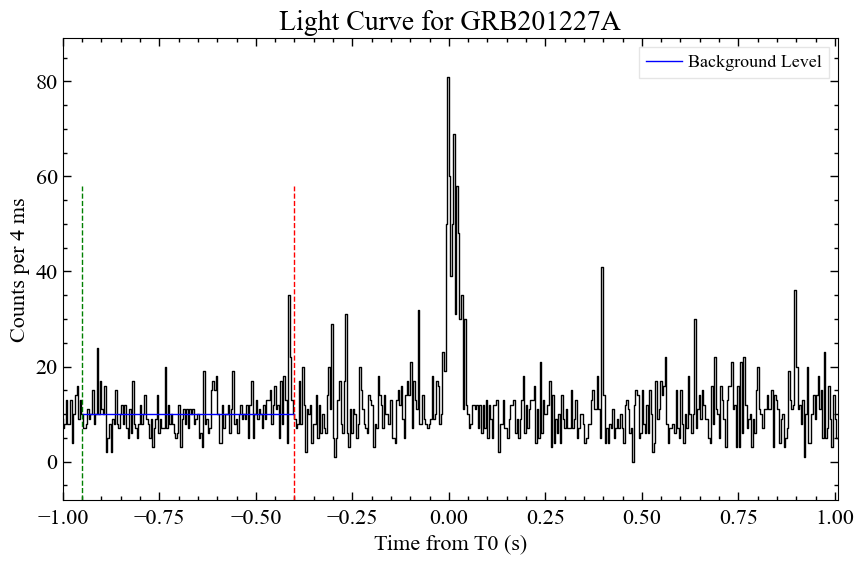

Mean background level: 10.0 / 0.004 [counts/s]


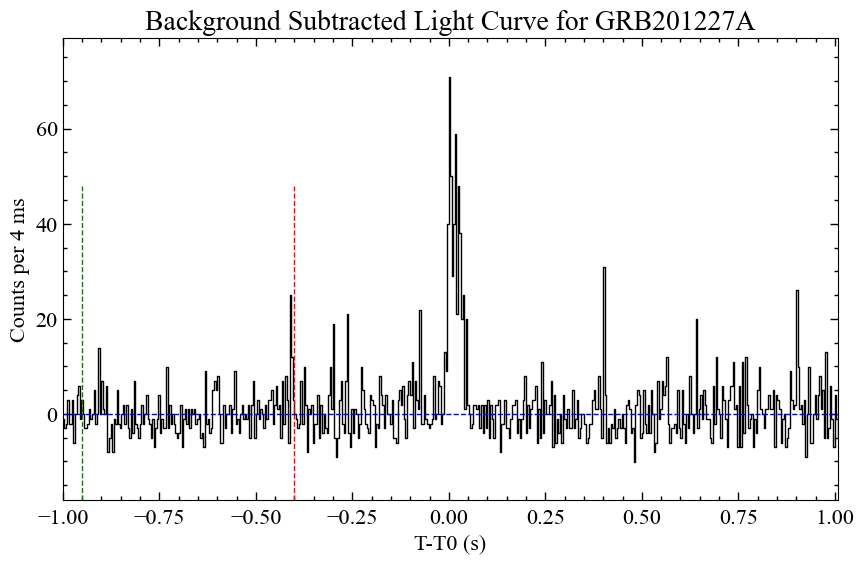

T90 for GRB201227A = 0.816 s
Mean total counts: 570.0 estimated from T0 0.415 --> 1.011


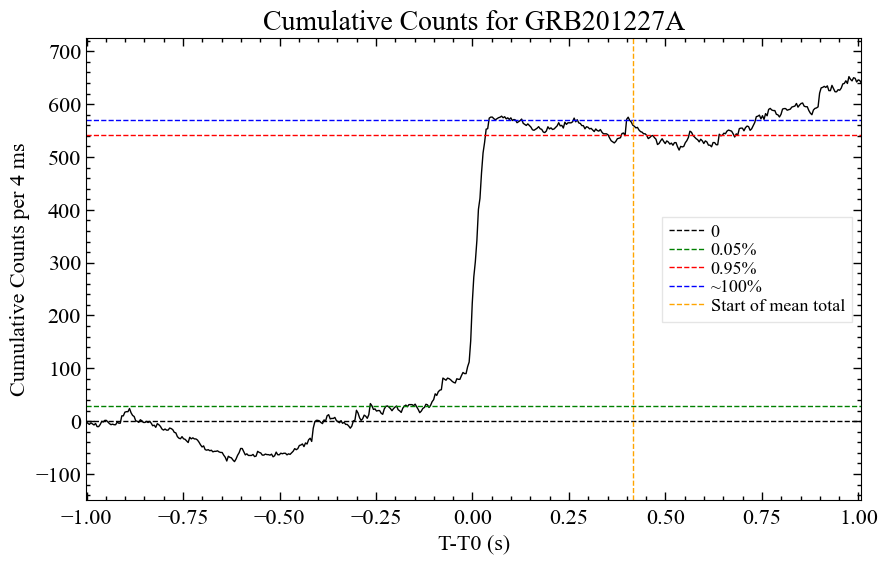

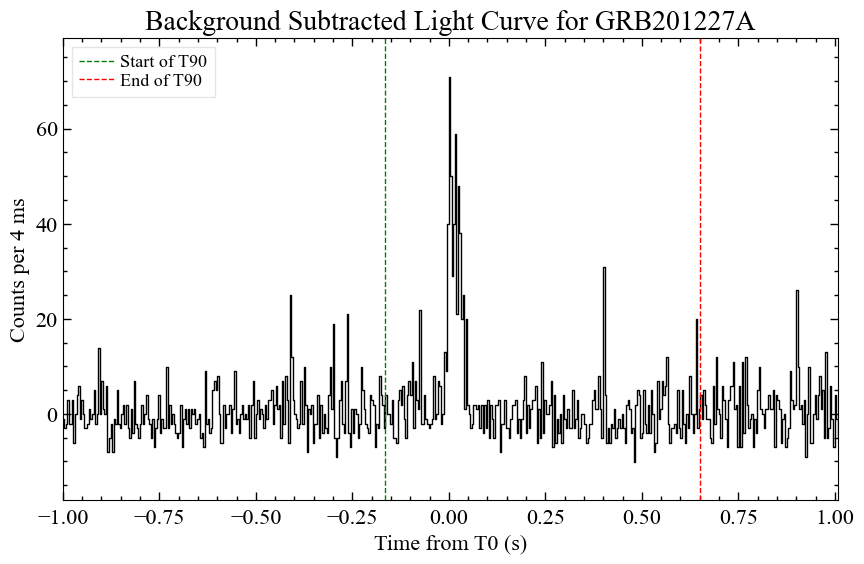

In [28]:
T90 = estimate_duration(GRB_id='GRB201227A', binsize=0.004,tlagg_asim=-0.531, T0='2020-12-27T15:14:06.853667', bak_interval=[(-0.95, -0.4)], mean_index=-150,poly_degree=0,
                    export=False, info_text=None)

## GRB 181222B
    - Need to use the data provided by Andrey; previously used data from David
        --> Calculate tlagg_asim again from Andrey data
        
    -Having trouble using the GUI from Andrey. Installed new CDF patch (390) but having trouble with the spdfcdfread (line 601) file. 
        --> Anyway, can access the T0 from the previously extracted datafiles from Andrey.

In [82]:
info_GRB181222B = "GRB181222B: Short and bright burst. Precoursor starts at around T0=2018-12-22 20:11:36.197430 (cross correlated with KW) \n\n T90 starts at peak in the precursor and ends at the end of the burst. \n\n Background: Stable. Polynomial approximation (0-th degree). 1. interval ti=T0-0.85 s, tf=T0-0.25 s. \n 2. interval: ti= T0+0.45 s tf=T0+1.0 s \n\n T90 estimations (binsize, Start time of the estimation of the mean total counts, T90):\n- 1ms, T0+0.5 s: 0.244 s\n- 2ms, - T0+0.5 s: 0.246 s\n- 4ms, - T0+0.5 s: 0.236 s\n- 8ms,  T0+0.5 s: 0.232 s\n- 16ms,  T0+0.5 s: 0.224 s\n\n T50 estimations (binsize, mean_start_time, T50):\n- 1ms, T0+0.5: 0.051 s\n- 2ms, T0+0.5: 0.052 s\n- 4ms, T0+0.5: 0.052 s\n- 8ms, T0+0.5: 0.048 s\n- 16ms, T0+0.5: 0.048 s"

T0 2018-12-22 20:11:36.197430, applied time lagg: -0.854 s


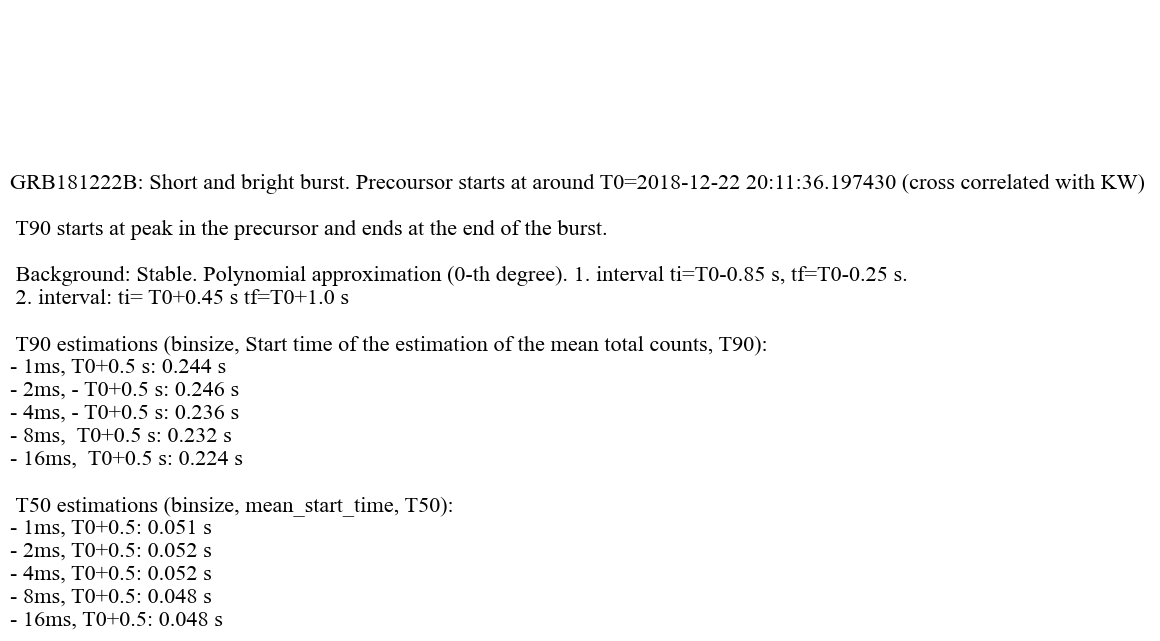

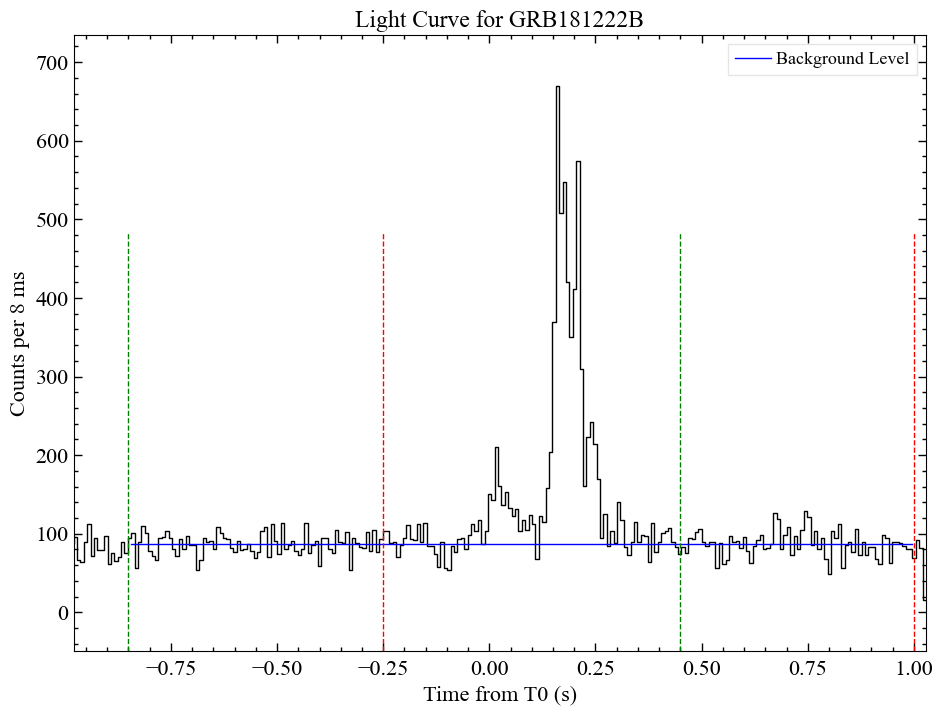

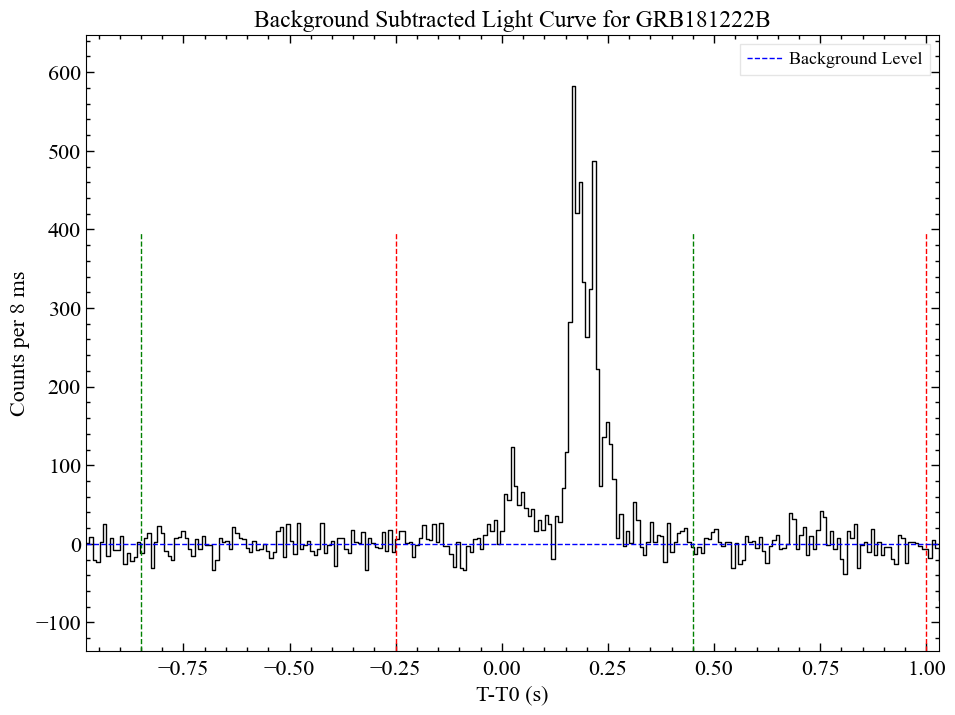

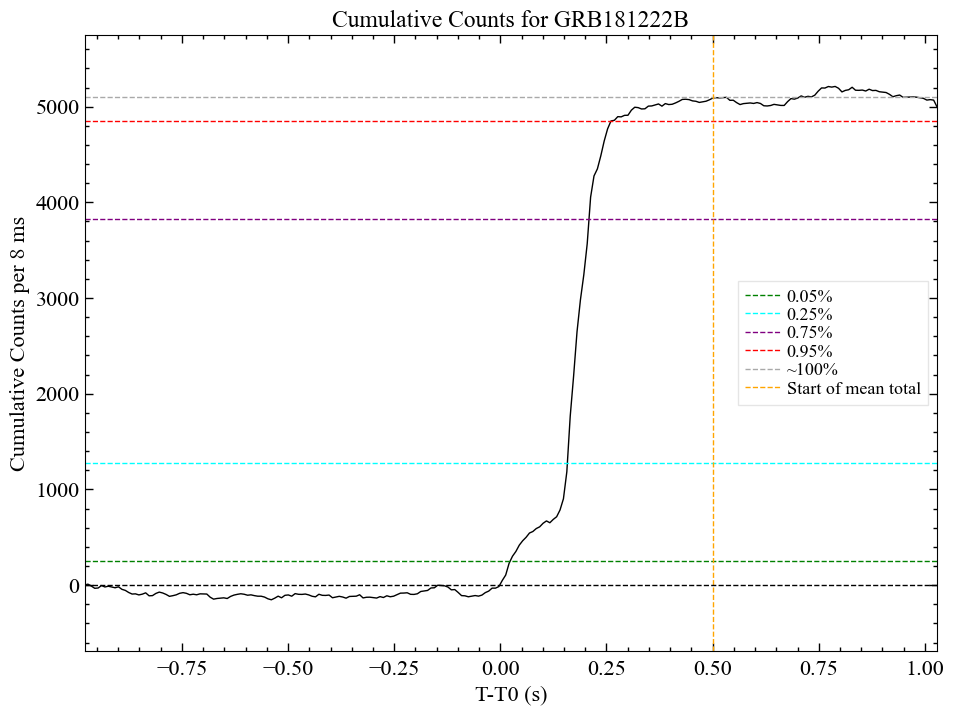

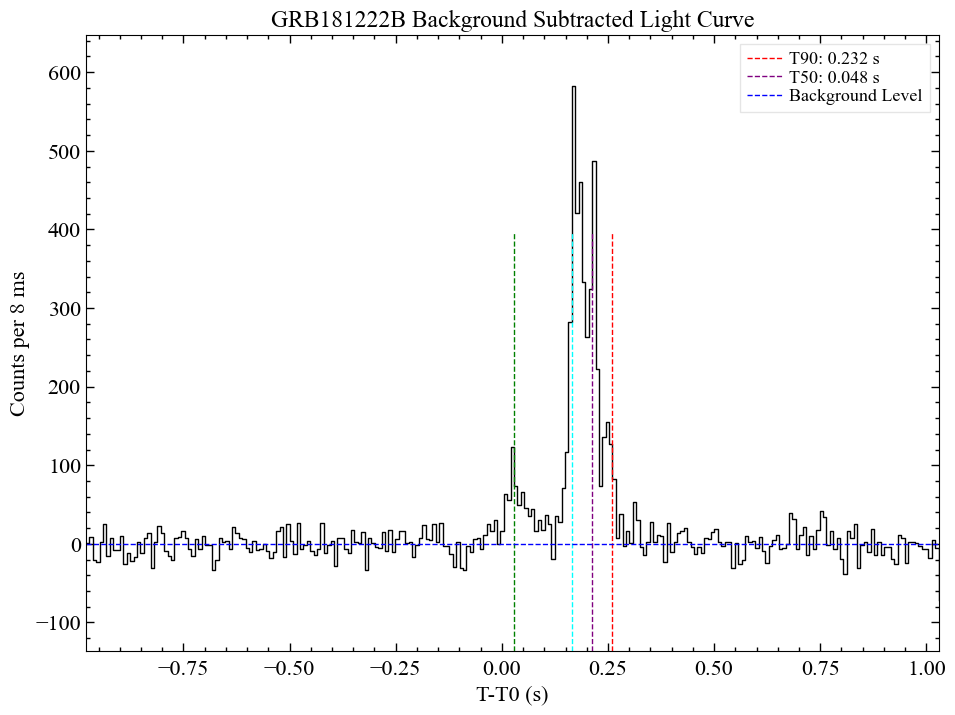

In [83]:
T90,T50 = estimate_duration(GRB_id='GRB181222B', binsize=0.008,tlagg_asim=-0.8540001094341279, T0='2018-12-22T20:11:37.051430',
                    bak_interval=[(-0.85, -0.25),(0.45,1.0)],mean_start_time=0.5,poly_degree=0, export=True, info_text=info_GRB181222B)

In [101]:
info_GRB200521A = "GRB200521: Relatively short burst, moderate count rate. \nT0=2020-05-21 12:16:39.630360 (cross correlated with KW) \n\n Background: Stable. Polynomial approximation (0-th degree). 1. interval ti=T0-0.90 s, tf=T0-0.10 s. \n 2. interval: ti= T0+0.40 s tf=T0+1.0 s \n\n T90 estimations (binsize, Start time of the estimation of the mean total counts, T90):\n- 1ms, T0+0.3 s: 0.173 s\n- 2ms, - T0+0.3 s: 0.174 s\n- 4ms, - T0+0.5 s: 0.172 s\n- 8ms,  T0+0.5 s: 0.168 s\n- 16ms,  T0+0.5 s: 0.176 s\n\n T50 estimations (binsize, mean_start_time, T50):\n- 1ms, T0+0.3 s: 0.075 s\n- 2ms, T0+0.3 s: 0.074 s\n- 4ms, T0+0.3 s: 0.076 s\n- 8ms, T0+0.3 s: 0.072 s\n- 16ms, T0+0.3 s: 0.08 s"

In [104]:
print(f'T90: {round(T90,3)}\nT50: {round(T50,3)}')

T90: 0.176
T50: 0.08


T0 2020-05-21 12:16:39.630360, applied time lagg: -0.814 s


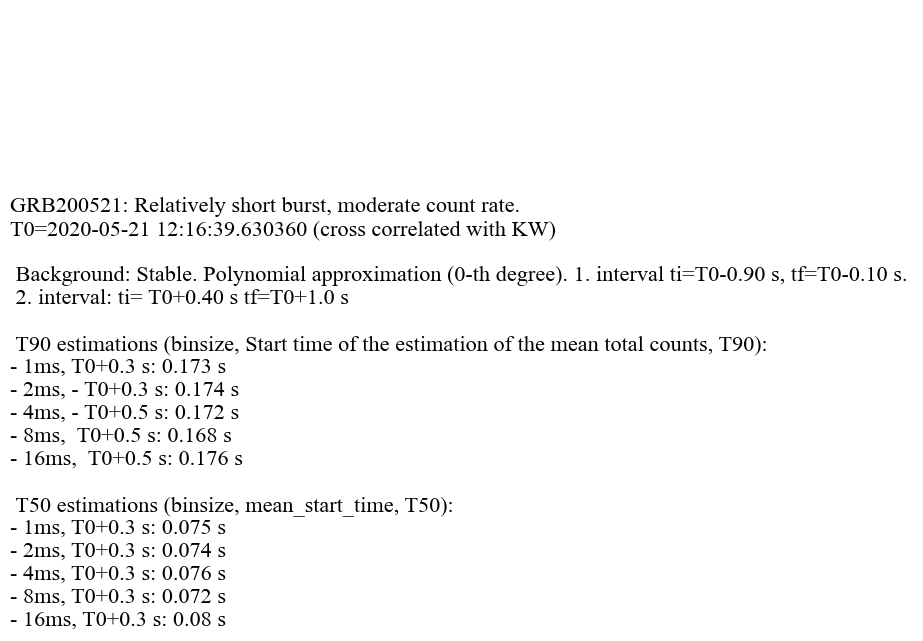

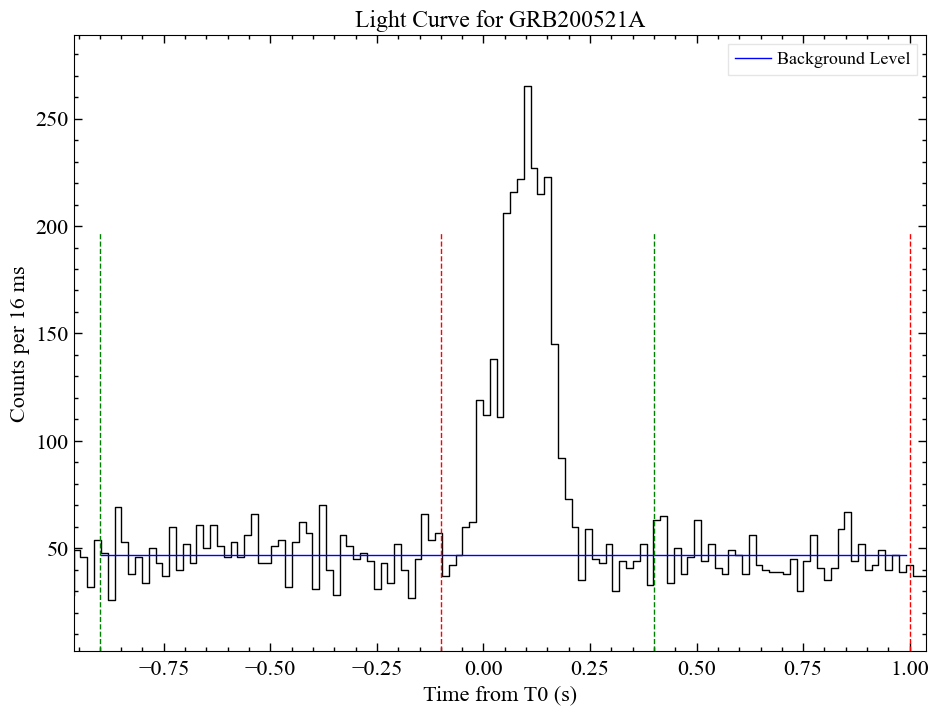

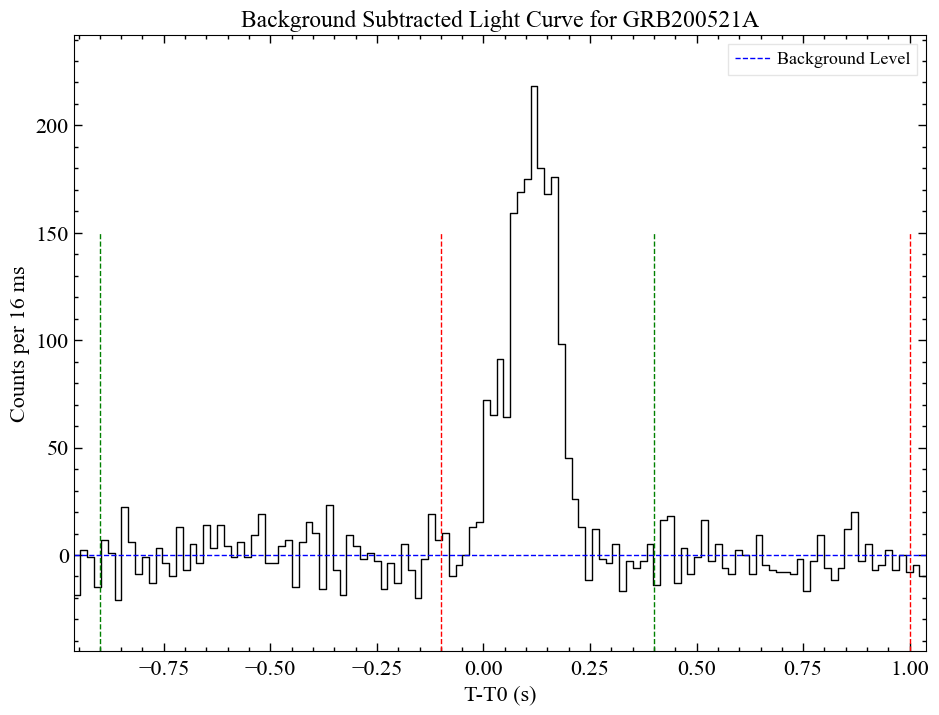

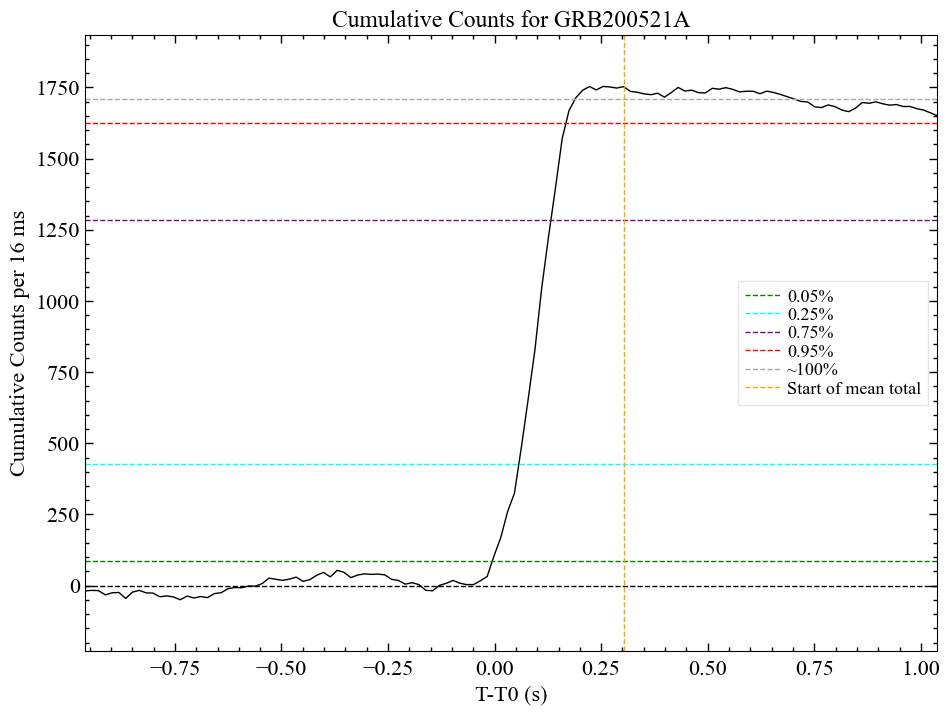

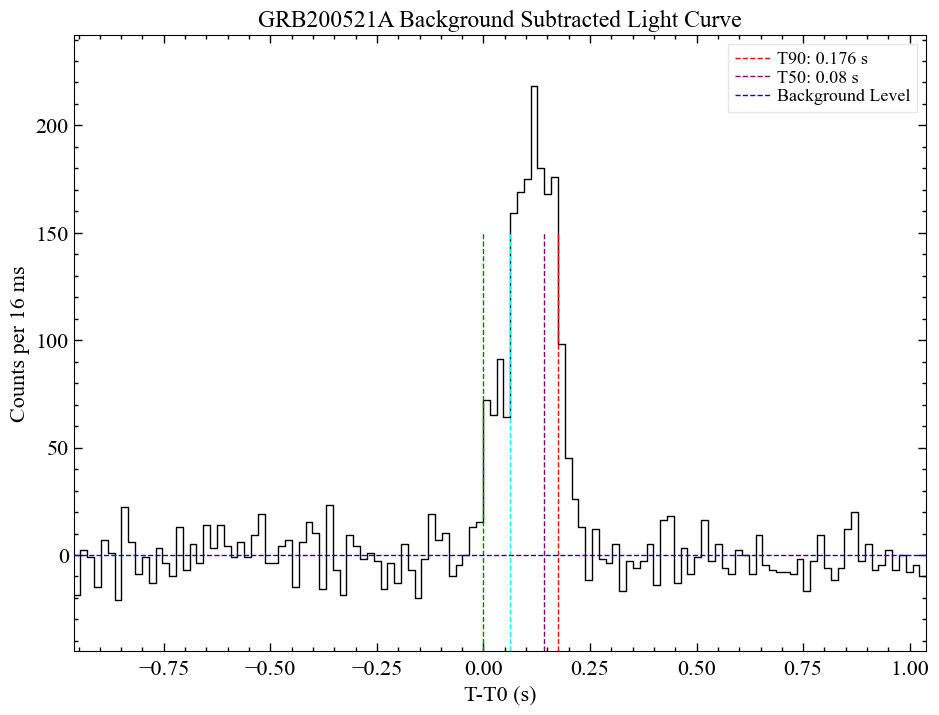

In [103]:
T90,T50 = estimate_duration(GRB_id='GRB200521A', binsize=0.016,tlagg_asim=-0.814, T0='2020-05-21T12:16:40.444360',
                    bak_interval=[(-0.9, -0.1),(0.4,1.0)],mean_start_time=0.3,poly_degree=0, export=True, info_text=info_GRB200521A)